In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import keras

width, height = 224, 224
batch_size = 16

path1 = "archive/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "archive/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "archive/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "archive/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "archive/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

data=[]
labels=[]

i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

labels = np.array(labels)
data = np.array(data)


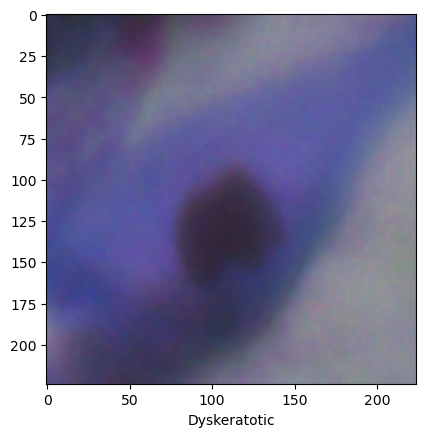

In [2]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])
    
show_the_image(5)

In [3]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(data)


augmented_data = []
augmented_labels = []
for x_batch, y_batch in datagen.flow(data, labels, batch_size=batch_size, shuffle=True):
    augmented_data.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_data) >= len(data) / batch_size:
        break


augmented_data = np.concatenate(augmented_data)
augmented_labels = np.concatenate(augmented_labels)


data = np.concatenate((data, augmented_data))
labels = np.concatenate((labels, augmented_labels))

print(data.shape)
print(labels.shape)
print(labels)

# Shuffle the data
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(8098, 224, 224, 3)
(8098,)
[0 0 0 ... 0 1 1]


In [4]:
from keras.applications.resnet import ResNet50
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
features_resnet       = model_resnet.predict(data, batch_size=32)
print(features_resnet.shape)

254/254 [==============================] - 733s 3s/step
(8098, 7, 7, 2048)


In [5]:
extracted_features = []
for f_v , label in zip(features_resnet, labels):
    f_v = f_v.reshape(f_v.shape[0] * f_v.shape[1] * f_v.shape[2])
    f_v = np.append(f_v, label)
    extracted_features.append(f_v)
    
extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(8098, 100353)


In [6]:
X=data
y=labels

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]


scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(scaled_X,y ,test_size=0.2, shuffle=True)
X_train, X_val,y_train, y_val = train_test_split(X_train,y_train ,random_state=41, test_size=0.25, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4858, 100352)
(1620, 100352)
(4858,)
(1620,)


Epoch 1/50
152/152 [==============================] - 115s 708ms/step - loss: 4.7591 - accuracy: 0.7888 - val_loss: 3.0535 - val_accuracy: 0.9080
Epoch 2/50
152/152 [==============================] - 107s 704ms/step - loss: 2.8457 - accuracy: 0.8658 - val_loss: 2.6740 - val_accuracy: 0.9056
Epoch 3/50
152/152 [==============================] - 107s 708ms/step - loss: 2.5315 - accuracy: 0.8726 - val_loss: 2.3398 - val_accuracy: 0.9025
Epoch 4/50
152/152 [==============================] - 109s 716ms/step - loss: 2.3419 - accuracy: 0.8652 - val_loss: 1.9472 - val_accuracy: 0.9228
Epoch 5/50
152/152 [==============================] - 104s 682ms/step - loss: 2.0756 - accuracy: 0.8771 - val_loss: 1.9723 - val_accuracy: 0.9198
Epoch 6/50
152/152 [==============================] - 103s 678ms/step - loss: 2.1183 - accuracy: 0.8765 - val_loss: 2.0219 - val_accuracy: 0.8932
Epoch 7/50
152/152 [==============================] - 104s 687ms/step - loss: 2.1007 - accuracy: 0.8623 - val_loss: 1.9684 -

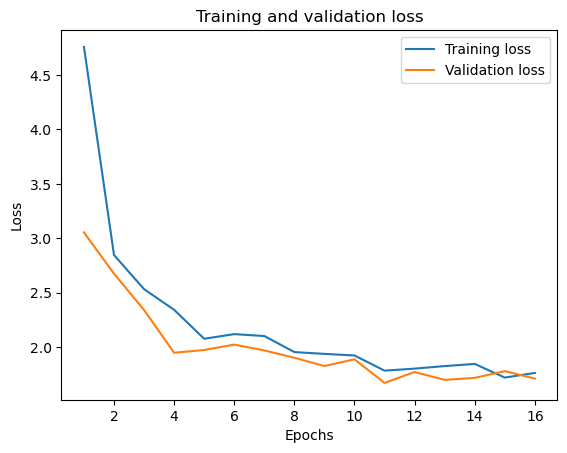

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


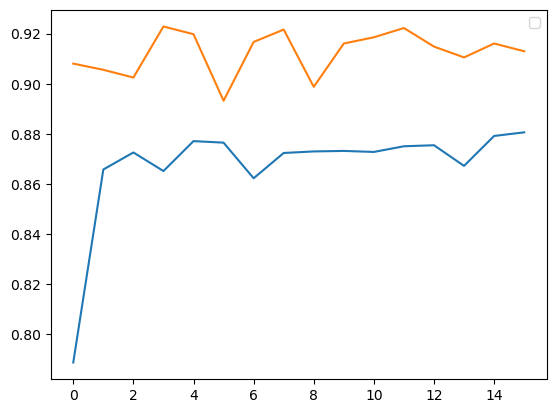

In [9]:
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('cervical_dl.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stop])

model.load_weights('cervical_dl.h5')
import time

start_time = time.time()

test_loss, test_acc = model.evaluate(X_test, y_test)

end_time = time.time()

print('Test accuracy:', test_acc)
print('Testing time:', end_time - start_time, 'seconds')


train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']

print(classification_report(y_test, y_pred_classes, target_names=target_names))


51/51 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

     class 0       0.94      0.93      0.93       343
     class 1       0.86      0.81      0.83       326
     class 2       0.88      0.89      0.88       320
     class 3       0.97      0.96      0.97       306
     class 4       0.91      0.97      0.94       325

    accuracy                           0.91      1620
   macro avg       0.91      0.91      0.91      1620
weighted avg       0.91      0.91      0.91      1620



51/51 [==============================] - 1s 27ms/step
Confusion matrix for Dyskeratotic:
[319  17   0   1   6]


Confusion matrix for Koilocytotic:
[ 16 263  28   3  16]


Confusion matrix for Metaplastic:
[  3  22 284   4   7]


Confusion matrix for Parabasal:
[  3   3   2 294   4]


Confusion matrix for Superficial-Intermediate:
[  0   2   8   0 315]




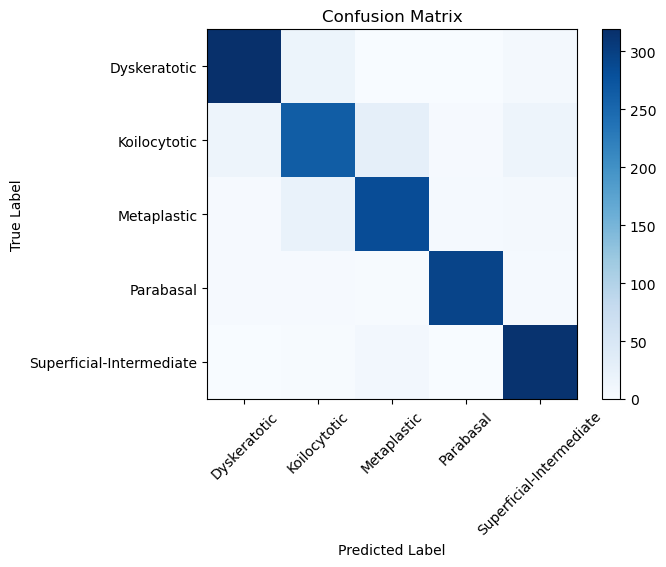

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])


for i in range(len(categories)):
    print(f"Confusion matrix for {categories[i]}:")
    print(cm[i])
    print("\n")

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [14]:
import lime
from lime import lime_image
import cv2
import os
from skimage.segmentation import mark_boundaries


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


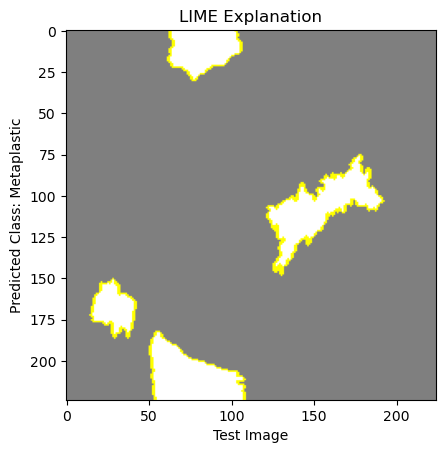

In [15]:
test_image_path = "249_01.bmp"
test_image = cv2.imread(test_image_path)
preprocessed_test_image = np.array(Image.fromarray(test_image, 'RGB').resize((height, width)))
explainer = lime_image.LimeImageExplainer()
def predict_fn(images):
    features = model_resnet.predict(images)
    features = features.reshape(features.shape[0], -1)
    scaled_features = scaler.transform(features)
    return model.predict(scaled_features)
explanation = explainer.explain_instance(preprocessed_test_image, predict_fn, top_labels=5, hide_color=0, num_samples=100)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.xlabel("Test Image")
plt.ylabel("Predicted Class: " + categories[np.argmax(predict_fn(preprocessed_test_image.reshape(1, height, width, 3)))])
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

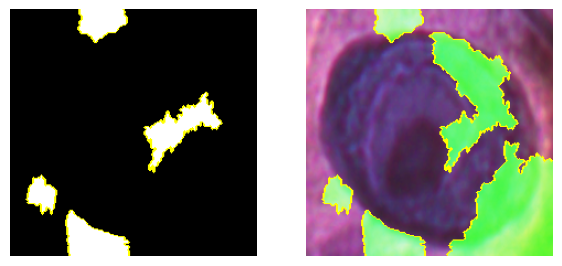

In [16]:
from skimage.segmentation import mark_boundaries
temp_11, mask_11 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_21, mask_21 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp_11, mask_11))
ax2.imshow(mark_boundaries(temp_21, mask_21))
ax1.axis('off')
ax2.axis('off')